In [55]:
using JuMP, Ipopt, Plots

Solving...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3988
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     6569

Total number of variables............................:     1004
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1003
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

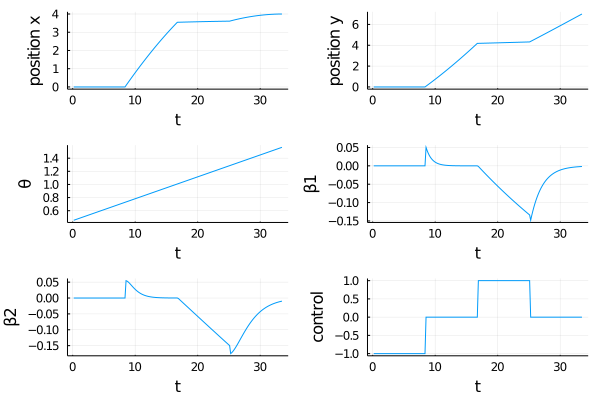


Cost : 8.370095081399906
t1 = 3.165339494155033e-5
t2 = 5.499800686906553
t3 = 5.652570194881209
tf = 8.370095081399906


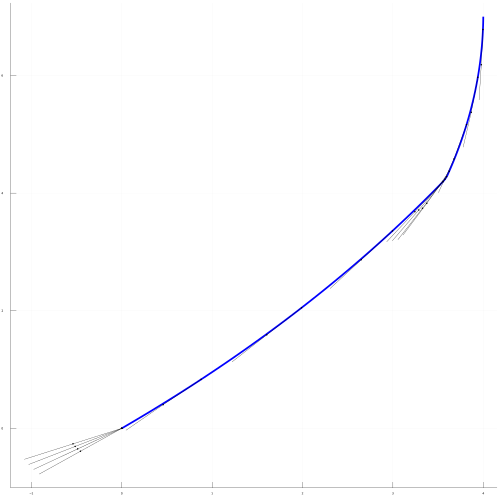

In [72]:
#JuMP model, Ipopt solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys,"tol",1e-14)
set_optimizer_attribute(sys,"max_iter",1000)

#Parameters

# constants
w = 0.0
l = 0.6
epsi = 10^(-2)

# initial data
x0 = 0 
y0 = 0 
θ0 = pi/7
β1_0 = 0 
β2_0 = 0


# final data
xf = 4
yf = 7
θf = pi/2 

N=50
m=50
p = 50
q=50
T = N+m+p+q

# Bounds for variables

JuMP.@variables(sys,begin
    x[1:T]           # x 
    y[1:T]           # y 
    θ[1:T]           # theta
    β1[1:T]          # beta1 
    β2[1:T]          # beta2
     0 ≤ Δt_1≤ 1 
     0 ≤ Δt_2≤ 1 
     0 ≤ Δt_3≤ 1 
     0 ≤ Δt_4≤ 1 
    end)

# Objective
@objective(sys,Min,Δt_1*N +Δt_2*(m)+ Δt_3*(p)+Δt_4*(q) )


# Constraints 

u=transpose([-ones(1,N) zeros(1,m) ones(1,p) zeros(1,q)])

@constraints(sys,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0
    β1[1]== β1_0
    β2[1] == β2_0
    x[T] == xf
    y[T] == yf
    θ[T] == θf
    β1[T]^2+β2[T]^2 ≤ epsi^2
        end)

# Dynamics : Crank-Nicolson scheme

for j in 1 : N-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt_1* (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt_1 *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt_1* (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt_1 * (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
end

@NLconstraint(sys,p_t1[j = 1:(N-1)],  # theta ' = u 
        θ[j+1] == θ[j] )

for j in N : N+m-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt_2 * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt_2 *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt_2* (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt_2* (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
end
@NLconstraint(sys,p_t2[j = N:(N+m-1)],  # theta ' = u 
        θ[j+1] == θ[j] )

for j in N+m : N+m+p-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt_3 * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt_3 *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt_3* (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt_3* (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
end

@NLconstraint(sys,p_t3[j = N+m:(N+m+p-1)],  # theta ' = u 
        θ[j+1] == θ[j] )

for j in N+m+p : T-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt_4* (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt_4 *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt_4 * (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt_4 * (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
end

@NLconstraint(sys,p_t4[j = N+m+p:(T-1)],  # theta ' = u 
        θ[j+1] == θ[j] )


#Solve for the control and state
println("Solving...")
status = optimize!(sys)
println("Solver status : ",status)
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
β_1 = value.(β1)
β_2 = value.(β2)
u1 = value.(u)
println("Cost : " , objective_value(sys))
#print("tf =",value.(Δt_ * T))
println("t1 = ",value.(Δt_1*N))
println("t2 = ",value.(Δt_1*N+Δt_2*m))
println("t3 = ",value.(Δt_1*N+Δt_2*m+Δt_3*p))
println("tf = ", value.(Δt_1*N+Δt_2*m+Δt_3*p+Δt_4*q))

#plots : states 

Δt = value.(Δt_1+Δt_2+Δt_3+Δt_4)
t = (1 : T)*(Δt)


x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false, fmt = :png)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false, fmt = :png)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false, fmt = :png)
β1_plot = plot(t,β_1,xlabel = "t", ylabel = "β1", legend = false, fmt = :png)
β2_plot = plot(t,β_2,xlabel = "t", ylabel = "β2", legend = false, fmt = :png)
u_plot = plot(t,u1,xlabel = "t", ylabel = "control", legend = false, fmt = :png)
display(plot(x_plot,y_plot,θ_plot,β1_plot,β2_plot,u_plot, layout = (3,2)))

#plots : trajectory 

p = plot(x1,y1, c = :blue, lw = 7)
plot!(size=(2000,2000))

for i = 1 :15: T-1
    z = [x1[i] y1[i]]
    θ_p = θ1[i]
    β1_p = β_1[i]
    β2_p = β_2[i]
    θ_1 =  β1_p +  θ_p
    θ_2 =  β2_p +  θ_p
    z1 = z - l*[cos(θ_1) sin(θ_1)]
    z2 = z1 - l*[cos(θ_2) sin(θ_2)]
    plot!([z[1],z1[1]], [z[2],z1[2]] ,color=:black, legend = false)
    plot!([z1[1],z2[1]], [z1[2],z2[2]], color=:black, legend = false)
    plot!([z[1]],[z[2]],seriestype = :scatter, color =:black , legend = false)
    plot!([z1[1]],[z1[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!(size=(2000,2000))
end
current()


In [69]:
print(value.(Δt_1),"  ")
print(value.(Δt_2),"  ")
print(value.(Δt_3),"  ")
print(value.(Δt_4),"  ")


0.028185024088856106  0.00026635587031335894  0.00026635587031335894  0.00026635587031335894  